In [1]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
from nf_slam.space_hashing_mapping.mapping import LearningConfig, OptimizerConfig, MapBuilder, ScanData,\
    init_map_model, BuildMapState
from nf_slam.plotting_utils import show_points, plot_nf_with_scans, plot_optimization_result,\
    plot_model_heatmap, plot_reconstructed_result
from nf_slam.tracking.tracking import OptimizePositionConfig, PositionOptimizer, \
    OptimizePositionState
from nf_slam.position_2d import Position2D
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import tqdm
import matplotlib.animation
import io
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 150
import flax.linen as nn
import dataclasses
from nf_slam.space_hashing_mapping.map_model import MapModel
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
import optax
import functools
import jax
import jax_dataclasses as jdc
from dataclasses import dataclass
from nf_slam.space_hashing_mapping.jax_math import calculate_layer_embeddings
from nf_slam.space_hashing_mapping.mapping import transform_points, calculate_points
from flax.optim.adam import Adam
from flax.optim import OptimizerState

ROS is not sourced. To enable ROS features, please source it


In [2]:
def get_points(laser_data_list, c="yellow", s=0.3):
    all_points = []
    for laser_data in laser_data_list:
        all_points.append(laser_data.as_points_in_odometry_frame())
    points = np.concatenate(all_points, axis=0)
    return points

In [3]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [4]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
# datafile = "/home/mikhail/Downloads/intel.log"
laser_data_list = dataset_loader.load(datafile)

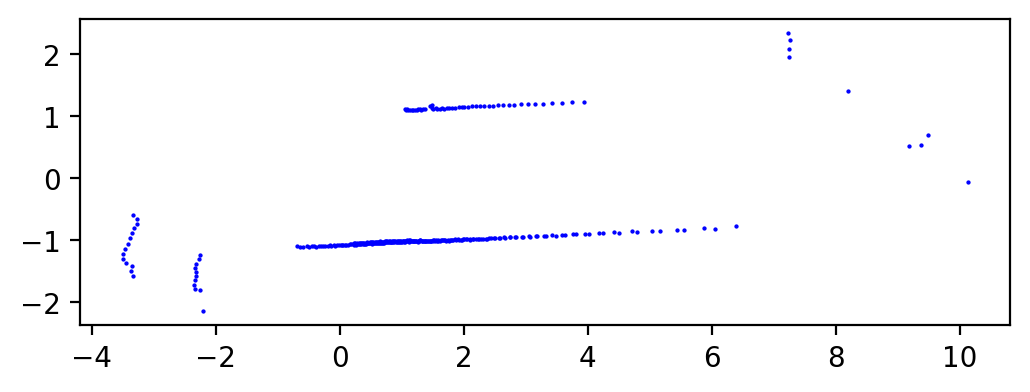

In [5]:
plt.figure(dpi=200)
show_points(laser_data_list[0:4:2], c="blue");

# Test map classification 

In [6]:
@dataclass(unsafe_hash=True)
class RectangleBoundary:
    min_x: float
    max_x: float
    min_y: float
    max_y: float
    
    @classmethod
    def from_vec(cls, vec):
        return cls(*vec)
    
    def apply(self, points):
        x = points[:, 0] * (self.max_x - self.min_x) + self.min_x
        y = points[:, 1] * (self.max_y - self.min_y) + self.min_y
        return jnp.stack([x, y], axis=1)

In [7]:
@jdc.pytree_dataclass
class LearningData:
    normal: jnp.array
    random_points: jnp.array
        
    @classmethod
    def from_config(cls, scan_data, config, key):
        random_points = jax.random.uniform(jax.random.PRNGKey(key), (config.random_point_count, 2))
        return cls(
            normal=jax.random.normal(jax.random.PRNGKey(key), 
                                     (len(scan_data.depths), config.sampling_depth_count)),
            random_points=config.random_point_boundary.apply(random_points))
        
        
@dataclass(unsafe_hash=True)
class MapModelConfig(object):
    minimal_depth: float
    maximal_depth: float
    F: int
    L: int
    T: int
    max_log_resolution: float
    min_log_resolution: float

@dataclass(unsafe_hash=True)
class MapBuildingConfig:
    sampling_depth_delta: float
    sampling_depth_count: int
    classification_loss_weight: float
    point_loss_weight: float
    random_point_boundary: RectangleBoundary
    random_point_loss_weight: float
    random_point_count: int

In [8]:
def calculate_densities(points: jnp.array, map_model: MapModel, model: MLPModel):
    embedding = calculate_layer_embeddings(map_model.hashtable,
                                           points,
                                           map_model.resolutions,
                                           map_model.origins,
                                           map_model.hashtable.shape[1],
                                           map_model.hashtable.shape[0],
                                           map_model.rotations)
    embedding = jnp.transpose(embedding, (1, 0, 2)).reshape(embedding.shape[1], -1)
    return model.apply(map_model.variables, embedding)

@jax.jit
def transform_points(points, position):
    x = position[..., 0, None]
    y = position[..., 1, None]
    angle = position[..., 2, None]
    transformed_x = x + points[..., 0] * jnp.cos(angle) - points[..., 1] * jnp.sin(angle)
    transformed_y = y + points[..., 0] * jnp.sin(angle) + points[..., 1] * jnp.cos(angle)
    return jnp.stack([transformed_x, transformed_y], axis=-1)

@functools.partial(jax.jit, static_argnums=[4, 5, 6])
def mapping_classification_loss(map_model: MapModel, position: jnp.array, scan_data: ScanData,
                 learning_data: LearningData, map_model_config: MapModelConfig, model: MLPModel,
                               config: MapBuildingConfig):
    sampling_depth_deltas = jnp.where(learning_data.normal > 0, config.sampling_depth_delta, 
                                     scan_data.depths[..., None] / 2)
    sampling_dephts = learning_data.normal * sampling_depth_deltas  + scan_data.depths[..., None]
    sampling_dephts = jnp.clip(sampling_dephts, 0, None)
    points = calculate_points(sampling_dephts, scan_data)
    points = transform_points(points, position).reshape(-1, 2)
    labels = (jnp.sign(learning_data.normal.reshape(-1)) + 1) / 2.
    densities = calculate_densities(points, map_model, model)
    labels = jnp.where(labels < 0.5, labels, 0.75 * jax.nn.sigmoid(densities) + 0.25)
    return optax.sigmoid_binary_cross_entropy(densities, labels).mean()

@functools.partial(jax.jit, static_argnums=[4, 5, 6])
def mapping_point_loss(map_model: MapModel, position: jnp.array, scan_data: ScanData,
                       learning_data: LearningData, map_model_config: MapModelConfig, model: MLPModel,
                               config: MapBuildingConfig):
    sampling_dephts = scan_data.depths[..., None]
    points = calculate_points(sampling_dephts, scan_data)
    points = transform_points(points, position).reshape(-1, 2)
    densities = calculate_densities(points, map_model, model)
    return (densities ** 2).mean()


@functools.partial(jax.jit, static_argnums=[4, 5, 6])
def random_mapping_point_loss(map_model: MapModel, position: jnp.array, scan_data: ScanData,
                       learning_data: LearningData, map_model_config: MapModelConfig, model: MLPModel,
                               config: MapBuildingConfig):
    points = learning_data.random_points
    densities = calculate_densities(points, map_model, model)
    return (densities ** 2).mean()

@functools.partial(jax.jit, static_argnums=[4, 5, 6])
def mapping_loss(map_model: MapModel, position: jnp.array, scan_data: ScanData,
                       learning_data: LearningData, map_model_config: MapModelConfig, model: MLPModel,
                               config: MapBuildingConfig):
    return config.point_loss_weight * mapping_point_loss(map_model, position, scan_data,
                       learning_data, map_model_config, model, config) +\
           config.classification_loss_weight * mapping_classification_loss(map_model, position, scan_data,
                       learning_data, map_model_config, model, config) +\
           config.random_point_loss_weight  * mapping_classification_loss(map_model, position, scan_data,
                       learning_data, map_model_config, model, config)
         

In [ ]:
learning_index = 30
points = get_points(laser_data_list[learning_index:learning_index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)


map_model_config = MapModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    F=4,
    L=16,
    T=4096,
    min_log_resolution=-0.5,
    max_log_resolution=2.,
)

map_building_config = MapBuildingConfig(
    sampling_depth_delta=3.,
    sampling_depth_count=200,
    point_loss_weight=1.,
    classification_loss_weight=1.,
    random_point_boundary=RectangleBoundary(*bounds),
    random_point_loss_weight=100.,
    random_point_count=100,
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=0.5e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-5,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=3e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)

mlp_model = MLPModel()
laser_data = laser_data_list[learning_index]
scan_data = ScanData.from_laser_data(laser_data)
map_model = init_map_model(mlp_model, map_model_config)
map_position = jnp.array(laser_data.odometry_position.as_vec())

variable_optimizer = Adam(**dataclasses.asdict(learning_config.variable_optimizer_config))
hashtable_optimizer = Adam(**dataclasses.asdict(learning_config.hashtable_optimizer_config))
        
loss_function = jax.jit(jax.value_and_grad(mapping_loss), static_argnums=[4, 5, 6])

state = BuildMapState(
            iteration=0,
            variable_state=variable_optimizer.init_state(map_model.variables),
            hashtable_state=hashtable_optimizer.init_state(map_model.hashtable)
)
loss_history = []
for i in tqdm.tqdm(range(learning_config.iterations)):
    learning_data = LearningData.from_config(scan_data, map_building_config, i)
    loss, grad = loss_function(map_model, map_position, scan_data, learning_data, map_model_config, mlp_model,
                            map_building_config)
    variables, variable_state = variable_optimizer.apply_gradient(
            variable_optimizer.hyper_params,
            map_model.variables,
            state.variable_state, grad.variables)
    hashtable, hashtable_state = hashtable_optimizer.apply_gradient(
            hashtable_optimizer.hyper_params,
            map_model.hashtable,
            state.hashtable_state, grad.hashtable)
    map_model = MapModel(hashtable=hashtable, variables=variables, resolutions=map_model.resolutions,
                             origins=map_model.origins, rotations=map_model.rotations)
    state = BuildMapState(state.iteration + 1, variable_state, hashtable_state)
    loss_history.append(loss)

In [ ]:
plt.plot(loss_history)

In [ ]:
def plot_model_heatmap(map_model: MapModel, bounds, model, grid_shape=(200, 200), vmin=None, vmax=None):
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], grid_shape[0]),
                                  jnp.linspace(bounds[2], bounds[3], grid_shape[1]))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilities = calculate_densities(grid, map_model, model)
    obstacle_probabilities = np.array(obstacle_probabilities).reshape(*grid_shape)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilities, cmap='RdBu', shading='auto',
                         vmin=vmin, vmax=vmax)
    plt.gca().set_aspect('equal')

In [ ]:
plt.figure(dpi=200)
value = 10
points = show_points(laser_data_list[learning_index:learning_index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(map_model, bounds, mlp_model, grid_shape=(1000, 1000), vmin=-value, vmax=value)
show_points(laser_data_list[learning_index:learning_index + 1], c="black");

# Tracking

In [ ]:
@functools.partial(jax.jit, static_argnums=[1, ])
def huber(input_array, delta):
#     result = delta ** 2 * (jnp.sqrt((1 + (input_array / delta) ** 2)) - 1)
#     result = jnp.sign(input_array) * jnp.sqrt(result)
    mask = jnp.abs(input_array) < delta
    result = jnp.where(mask, input_array, jnp.sign(input_array) * (delta * (2 * jnp.abs(input_array) - delta)) ** 0.5)
    return result

@functools.partial(jax.jit, static_argnums=[4, 5, 6])
def calculate_deltas(map_model: MapModel, position: jnp.array, scan_data: ScanData,
                       learning_data: LearningData, map_model_config: MapModelConfig, model: MLPModel, 
                    map_building_config):
    sampling_dephts = scan_data.depths[..., None]
    points = calculate_points(sampling_dephts, scan_data)
    points = transform_points(points, position).reshape(-1, 2)
    densities = calculate_densities(points, map_model, model)
    deltas = huber(densities, 2)
    deltas = deltas / jnp.sqrt(scan_data.depths.shape[0])
    return deltas

@functools.partial(jax.jit, static_argnums=[4, 5, 6])
def tracking_loss(map_model: MapModel, position: jnp.array, scan_data: ScanData,
                       learning_data: LearningData, map_model_config: MapModelConfig, model: MLPModel,
                 map_building_config):
    return (calculate_deltas(map_model, position, scan_data, learning_data, map_model_config, model,
                            map_building_config) ** 2).sum()

In [ ]:
@dataclasses.dataclass
class OptimizePositionConfig:
    learning_rate: float
    iterations: int  # 100
    init_hessian: jnp.array  # jnp.diag(jnp.array([2000, 2000, 200]))
    maximal_clip_norm: float  # 30
    beta1: float  # 0.7
    beta2: float  # 0.4
    hessian_adder: jnp.array  # jnp.diag(jnp.array([20, 20, 2]))
        
@dataclasses.dataclass
class OptimizePositionState:
    iteration: int
    previous_hessian: jnp.array
    previous_grad: jnp.array


In [ ]:
tracking_config = OptimizePositionConfig(
    learning_rate=0.9,
    iterations=100,
    init_hessian=jnp.diag(jnp.array([200, 200, 200])),
    maximal_clip_norm=100,
    beta1=0.5,
    beta2=0.3,
    hessian_adder=jnp.diag(jnp.array([200, 200, 200])) * 0.01
)

In [ ]:
jacobian_function = jax.jit(jax.jacfwd(calculate_deltas, argnums=1), static_argnums=[4, 5, 6])

tracking_index = 30
laser_data = laser_data_list[tracking_index]
scan_data = ScanData.from_laser_data(laser_data)
# optimized_position = jnp.array([0, -1, 2.7])
# optimized_position = jnp.array([0.656, -1, 4])
# optimized_position = jnp.array([-0.5, 1., 2.77])
optimized_position = jnp.array(laser_data_list[tracking_index].odometry_position.as_vec())
optimized_position = optimized_position + jnp.array([0, 0, 0])
# optimized_position = jnp.array([0.656165, 0.0812728,  3])
init_optimized_position = optimized_position

state = OptimizePositionState(0, tracking_config.init_hessian, jnp.zeros(3))
loss_history = []
position_history = []
hessian_history = []
grad_history = []
hessian_adder = tracking_config.hessian_adder
for i in tqdm.tqdm(range(tracking_config.iterations)):
        learning_data = LearningData.from_config(scan_data, map_building_config, i)
        jacobian = jacobian_function(map_model, optimized_position, scan_data,
                                          learning_data,
                                          map_model_config, mlp_model, map_building_config)
        jacobian_norm = jnp.linalg.norm(jacobian, axis=1) + 1e-4
        clipped_norm = jnp.clip(jacobian_norm, 0, tracking_config.maximal_clip_norm)
#         jacobian = jacobian / jacobian_norm[:, None] * clipped_norm[:, None]
        depth_deltas = calculate_deltas(map_model, optimized_position, scan_data,
                                              learning_data, map_model_config, mlp_model, map_building_config)
        grad = 2 * jnp.sum(jacobian * depth_deltas[:, None], axis=0)
        
        hessian = 2 * jacobian.T @ jacobian
        
        grad = tracking_config.beta2 * state.previous_grad + (1 - tracking_config.beta2) * grad
        grad_history.append(grad)
        hessian = tracking_config.beta1 * state.previous_hessian + (1 - tracking_config.beta1) * hessian
        hessian_history.append(hessian)
        previous_hessian = hessian
        hessian = hessian + hessian_adder
#         hessian_adder = hessian_adder * 0.95
        delta = -(jnp.linalg.inv(hessian) @ grad) * tracking_config.learning_rate
        optimized_position = optimized_position + delta
        previous_grad = grad + hessian @ delta
        state = OptimizePositionState(state.iteration + 1, previous_hessian, previous_grad)
        loss = tracking_loss(map_model, optimized_position, scan_data, learning_data, map_model_config, mlp_model,
                            map_building_config)
        loss_history.append(loss)
        position_history.append(Position2D.from_vec(np.array(optimized_position)))

print("Truth position", laser_data.odometry_position.as_vec())
print("Init position", init_optimized_position)
print("Result position", optimized_position)

In [ ]:
plt.plot(loss_history)
print()

In [ ]:
plt.plot([x[0, 0] for x in hessian_history])

In [ ]:
plt.plot([x[2] for x in grad_history])

In [ ]:
def plot_position_history(position_history):
    positions = Position2D.from_array(position_history).as_vec()
    plt.plot(positions[:, 0], positions[:, 1])
    plt.quiver(positions[:, 0], positions[:, 1], np.cos(positions[:, 2]), np.sin(positions[:, 2]), scale=25)
    
def plot_position(positions):
    plt.quiver(positions[None, 0], positions[None, 1], np.cos(positions[None, 2]), 
               np.sin(positions[None, 2]), scale=10, color="red")
    
    
def show_points_in_frame(laser_data_list, frame, c="yellow", s=0.3):
    all_points = []
    for laser_data in laser_data_list:
        all_points.append(laser_data.as_points())
    points = np.concatenate(all_points, axis=0)
    points = frame.apply(points)
    plt.scatter(points[:, 0], points[:, 1], s=s, c=c)
    plt.gca().set_aspect("equal")
    return points

In [ ]:
plt.figure(dpi=200)
laser_data = laser_data_list[tracking_index]
plot_model_heatmap(map_model, bounds, mlp_model, grid_shape=(1000, 1000), vmin=-value, vmax=value)
show_points_in_frame(laser_data_list[tracking_index:tracking_index + 1], 
                     Position2D.from_vec(np.array(optimized_position)),
                     c="black");

bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
show_points(laser_data_list[tracking_index:tracking_index + 1])
show_points(laser_data_list[learning_index:learning_index + 1], c="red")
plot_position(laser_data.odometry_position.as_vec())
plot_position_history(position_history)
plt.gca().set_aspect('equal')

In [ ]:
angles = jnp.linspace(-np.pi, np.pi, 1000)
optimized_position = jnp.array(laser_data_list[tracking_index].odometry_position.as_vec())
positions = [optimized_position + jnp.array([0, 0, x]) for x in angles]
laser_data = laser_data_list[tracking_index]
scan_data = ScanData.from_laser_data(laser_data)
losses = []
for position in tqdm.tqdm(positions):
#     loss = tracking_loss(map_model, position, scan_data, learning_data, map_model_config, mlp_model, map_building_config)
    loss = mapping_loss(map_model, position, scan_data, learning_data, map_model_config, mlp_model, map_building_config)
    losses.append(loss)

In [ ]:
plt.figure(dpi=200)
plt.plot(angles, losses)

In [ ]:
plt.figure(dpi=200)
plt.polar(angles, losses)
plt.title("Loss function from angle")

In [ ]:
angles = jnp.linspace(-np.pi, np.pi, 1000)
optimized_position = jnp.array(laser_data_list[tracking_index].odometry_position.as_vec())
positions = [optimized_position + jnp.array([0, 0, x]) for x in angles]
laser_data = laser_data_list[tracking_index]
scan_data = ScanData.from_laser_data(laser_data)
losses = []
for position in tqdm.tqdm(positions):
    loss = tracking_loss(map_model, position, scan_data, learning_data, map_model_config, mlp_model, map_building_config)
#     loss = mapping_loss(map_model, position, scan_data, learning_data, map_model_config, mlp_model, map_building_config)
    losses.append(loss)

In [ ]:
plt.figure(dpi=200)
plt.plot(angles, losses)

In [ ]:
plt.figure(dpi=200)
plt.polar(angles, losses)
plt.title("Loss function from angle")

In [ ]:
xs = jnp.linspace(-4, 2, 1000)
positions = [optimized_position + jnp.array([x, 0, 0]) for x in xs]
laser_data = laser_data_list[tracking_index]
scan_data = ScanData.from_laser_data(laser_data)
losses = []
for position in tqdm.tqdm(positions):
    loss = mapping_loss(map_model, position, scan_data, learning_data, map_model_config, mlp_model, map_building_config)
    losses.append(loss)

In [ ]:
plt.figure(dpi=200)
plt.plot(xs, losses)

In [ ]:
xs = jnp.linspace(-4, 2, 1000)
positions = [optimized_position + jnp.array([x, 0, 0]) for x in xs]
laser_data = laser_data_list[tracking_index]
scan_data = ScanData.from_laser_data(laser_data)
losses = []
for position in tqdm.tqdm(positions):
    loss = tracking_loss(map_model, position, scan_data, learning_data, map_model_config, mlp_model, map_building_config)
    losses.append(loss)

In [ ]:
plt.figure(dpi=200)
plt.plot(xs, losses)